# Intro to Data

In [1]:
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
%matplotlib inline

from neurodsp import filt

In [63]:
data = spio.loadmat('./data/2002.mat')

In [64]:
task = data['oz_trial_data'][0]
print(task)
print(len(task))
rest = data['oz_rest_data'][0]
print(rest)
print(len(rest))

[ 71.44241333  70.53683472  73.16766357 ...,  45.49458313  50.58727264
  46.46075439]
60000
[ -9.71532059  -6.24306011  -1.59941649 ...,  38.5237236   45.48579407
  45.83069611]
60000


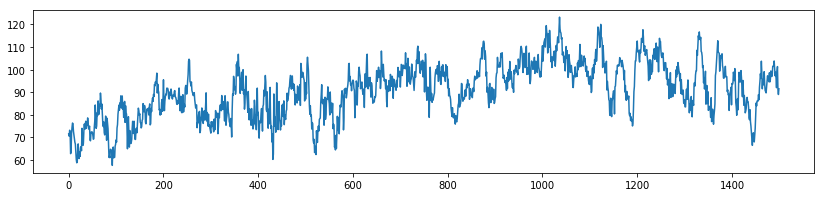

In [4]:
plt.figure(figsize=(14, 3));
plt.plot(task[:1500]);

That needs to be filtered.

In [5]:
task_f = filt.filter(task, 500, 'bandpass', f_lo=2, f_hi=50)
rest_f = filt.filter(rest, 500, 'bandpass', f_lo=2, f_hi=50)

# remove NaN values (result of filter width)
task_f = task_f[~np.isnan(task_f)]
rest_f = rest_f[~np.isnan(rest_f)]

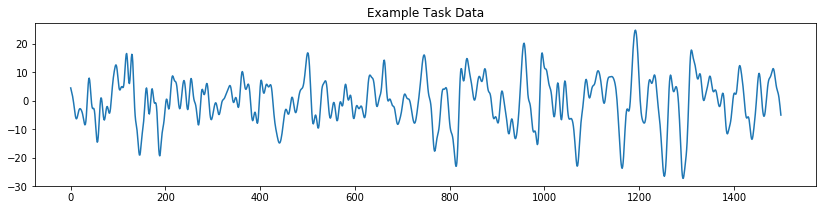

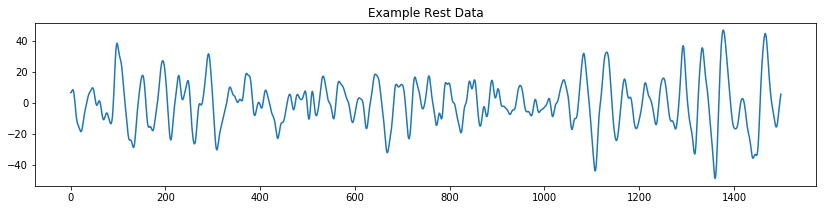

In [6]:
plt.figure(figsize=(14, 3));
plt.title('Example Task Data');
plt.plot(task_f[:1500]);

plt.figure(figsize=(14, 3));
plt.title('Example Rest Data');
plt.plot(rest_f[:1500]);

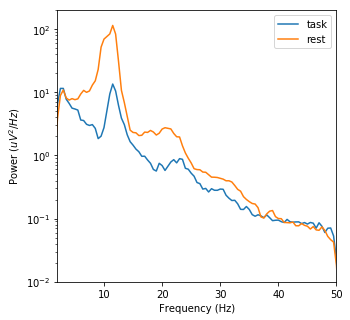

In [51]:
from scipy import signal
f_task, psd_task = signal.welch(task_f, 500, nperseg=1000)
f_rest, psd_rest = signal.welch(rest_f, 500, nperseg=1000)

# Plot power spectra
plt.figure(figsize=(5,5));
plt.semilogy(f_task, psd_task, label='task');
plt.semilogy(f_rest, psd_rest, label='rest');
plt.legend(loc='best');
plt.ylim((.01, 200));
plt.xlim((2,50));
plt.ylabel('Power ($uV^{2}/Hz$)');
plt.xlabel('Frequency (Hz)');

# Define Training and Test Sets

In [2]:
SAMPLE_LENGTH = 250 # 250 samples at 500 Hz = 0.5 sec
x_train = np.zeros(SAMPLE_LENGTH)
#y_train = np.zeros((1, 2))
y_train = np.zeros(1)

for s in range(10):
    # Load data from current file
    data = spio.loadmat('./data/200' + str(s) + '.mat')
    task = data['oz_trial_data'][0]
    rest = data['oz_rest_data'][0]
    print len(task)
    print len(rest)
    
    # Filter data
    task = filt.filter(task, 500, 'bandpass', f_lo=2, f_hi=50)
    rest = filt.filter(rest, 500, 'bandpass', f_lo=2, f_hi=50)

    # Remove NaN values (result of filter width)
    task = task[~np.isnan(task)]
    rest = rest[~np.isnan(rest)]
    
    # Chunk data and add each chunk to x_train
    i = SAMPLE_LENGTH
    while i < len(task):
        x_train = np.vstack([x_train, task[i-SAMPLE_LENGTH : i]])
        i += SAMPLE_LENGTH
        y_train = np.vstack([y_train, np.array([1])]) # 1 for eyes open
        #y_train = np.vstack([y_train, np.array([0, 1])]) # for one hot encoding labels, [0, 1] for eyes open
    
    # Repeat for rest data (eyes closed)
    i = SAMPLE_LENGTH
    while i < len(task):
        x_train = np.vstack([x_train, rest[i-SAMPLE_LENGTH : i]])
        i += SAMPLE_LENGTH
        y_train = np.vstack([y_train, np.array([0])]) # 0 for eyes open
        #y_train = np.vstack([y_train, np.array([1, 0])]) # [1, 0] for eyes closed
    
    print "Subject {s}'s data loaded and filtered".format(s=s)
    
# Remove zeros leftover from initialization
x_train = x_train[1:]
y_train = y_train[1:]

# Split into test and train
test_idx = int(0.1 * len(x_train))
x_test = x_train[-test_idx:]
y_test = y_train[-test_idx:]
x_train = x_train[:-test_idx]
y_train = y_train[:-test_idx]

print '\ntrain set {length} examples long'.format(length=len(x_train))
print 'test set {length} examples long'.format(length=len(x_test))

60000
60000
Subject 0's data loaded and filtered
60000
60000
Subject 1's data loaded and filtered
60000
60000
Subject 2's data loaded and filtered
60000
60000
Subject 3's data loaded and filtered
60000
60000
Subject 4's data loaded and filtered
60000
60000
Subject 5's data loaded and filtered
60000
60000
Subject 6's data loaded and filtered
60000
60000
Subject 7's data loaded and filtered
60000
60000
Subject 8's data loaded and filtered
60000
60000
Subject 9's data loaded and filtered

train set 4248 examples long
test set 472 examples long


In [3]:
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))
print np.sum(y_train)
print np.sum(y_test)

(4248, 250)
(4248, 1)
(472, 250)
(472, 1)
2124.0
236.0


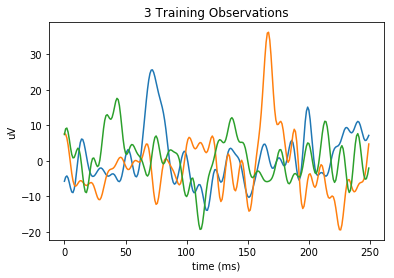

In [4]:
for i in range(3):
    t = np.arange(250)
    plt.title('3 Training Observations')
    plt.xlabel('time (ms)')
    plt.ylabel('uV')
    plt.plot(t, x_train[i])

# Baseline Classifier

In [5]:
from neurodsp import amp_by_time

In [6]:
# Get alpha power distributions for eyes open and eyes closed

eyes_open_mean_power = np.array([])
eyes_closed_mean_power = np.array([])

for i in range(len(x_train)):
    x_amplitude = amp_by_time(x_train[i], 500, (8,12))
    trial_mean_power = np.mean(np.power(x_amplitude, 2))
    
    if y_train[i] == 1:
        eyes_open_mean_power = np.hstack([eyes_open_mean_power, trial_mean_power])
    else:
        eyes_closed_mean_power = np.hstack([eyes_closed_mean_power, trial_mean_power])
        
print 'Eyes Open Median Alpha Power: {p}'.format(p=np.median(eyes_open_mean_power))
print 'Eyes Closed Median Alpha Power: {p}'.format(p=np.median(eyes_closed_mean_power))

Eyes Open Median Alpha Power: 19.0007481241
Eyes Closed Median Alpha Power: 130.188162572


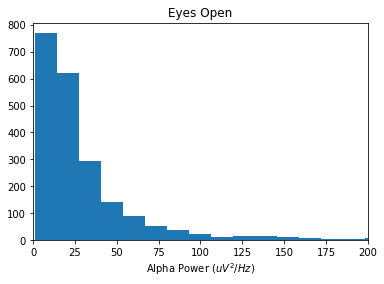

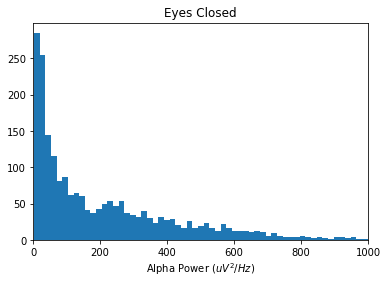

In [347]:
plt.title('Eyes Open');
plt.xlim(0, 200)
plt.xlabel('Alpha Power ($uV^{2}/Hz$)')
plt.hist(eyes_open_mean_power, bins=100);

plt.figure();
plt.title('Eyes Closed');
plt.xlim(0, 1000)
plt.xlabel('Alpha Power ($uV^{2}/Hz$)')
plt.hist(eyes_closed_mean_power, bins=100);

In [8]:
# Actual Classifier: eyes closed if mean alpha power > 20

correct = 0.0

for i in range(len(x_test)):
    x_amplitude = amp_by_time(x_test[i], 500, (8,12))
    trial_mean_power = np.mean(np.power(x_amplitude, 2))
    
    if y_test[i] == 0 and trial_mean_power > 20:
        correct += 1
accuracy = correct / len(x_test)
print 'Testing Accuracy: {a}'.format(a=accuracy)

# Training accuracy
correct = 0.0
for i in range(len(x_train)):
    x_amplitude = amp_by_time(x_train[i], 500, (8,12))
    trial_mean_power = np.mean(np.power(x_amplitude, 2))
    if y_train[i] == 0 and trial_mean_power > 20:
        correct += 1
accuracy = correct / len(x_train)
print 'Training Accuracy: {a}'.format(a=accuracy)

Testing Accuracy: 0.408898305085
Training Accuracy: 0.428907721281


# Machine Learning

In [10]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Conv1D, GlobalAveragePooling1D, MaxPooling1D, Dropout, BatchNormalization

Using TensorFlow backend.


# LSTM

In [127]:
# LSTM

data_dim = 1
timesteps = 250
num_classes = 1

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(250, return_sequences=True,
               input_shape=(timesteps, data_dim)))
model.add(LSTM(250, return_sequences=True))
model.add(LSTM(5))
model.add(Dense(num_classes, activation='sigmoid'))

In [130]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [131]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [132]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 198s 47ms/step - loss: 0.6045 - acc: 0.6702

In [133]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [134]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 10s 20ms/step
Accuracy: 0.61016949102
Loss 0.654865523516


# CNN #1
Using the architecture from this [Keras tutorial](https://keras.io/getting-started/sequential-model-guide/)

In [335]:
model = Sequential()

model.add(Conv1D(64, 3, activation='relu', input_shape=(250, 1)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [336]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [337]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [338]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 15s 4ms/step - loss: 0.6126 - acc: 0.6441

In [339]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [340]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 2s 4ms/step
Accuracy: 0.809322033898
Loss 0.466515521882


# CNN, ELU
Swap ReLU with ELU as [Schirrmeister et. al.](https://arxiv.org/abs/1703.05051) suggest.

In [21]:
model = Sequential()

model.add(Conv1D(64, 3, activation='elu', input_shape=(250, 1)))
model.add(Conv1D(64, 3, activation='elu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='elu'))
model.add(Conv1D(128, 3, activation='elu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [24]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 10s 2ms/step - loss: 0.5797 - acc: 0.6916

In [25]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [26]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 0s 1ms/step
Accuracy: 0.766949151532
Loss 0.483215945252


# CNN w/ Batch Normalization
Otherwise, same as above

In [341]:
# Option 3: CNN with batch normalization (good)
model = Sequential()

model.add(Conv1D(64, 3, activation='relu', input_shape=(250, 1)))
model.add(BatchNormalization())

model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [342]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [343]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [344]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 25s 6ms/step - loss: 0.5046 - acc: 0.7516

In [345]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [346]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 3s 6ms/step - ETA: 0s
Accuracy: 0.764830507464
Loss 0.475243263325


# CNN w/ Batch Normalization and Sigmoid Activation

In [249]:
# Option 3: CNN with batch normalization (good)
model = Sequential()

model.add(Conv1D(64, 3, activation='sigmoid', input_shape=(250, 1)))
model.add(BatchNormalization())

model.add(Conv1D(64, 3, activation='sigmoid'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(128, 3, activation='sigmoid'))
model.add(BatchNormalization())

model.add(Conv1D(128, 3, activation='sigmoid'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [250]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [251]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [252]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 25s 6ms/step - loss: 0.5173 - acc: 0.7436

In [253]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [254]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 2s 4ms/step
Accuracy: 0.807203390841
Loss 0.465329771325


# CNN w/ Bigger Filter Kernels

In [10]:
# Option 4: CNN with batch normalization (good)
model = Sequential()

model.add(Conv1D(64, 16, activation='relu', input_shape=(250, 1)))
model.add(BatchNormalization())

model.add(Conv1D(64, 16, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(128, 8, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(128, 8, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [13]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 33s 8ms/step - loss: 0.5195 - acc: 0.7528

In [14]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [15]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 2s 3ms/step
Accuracy: 0.764830507464
Loss 0.503720365338


This decreased the testing accuracy, but also increased the final training accuracy. That being said, it didn't have a big difference on either. Notice the ~30% increase in training time, though.

# CNN, Omit MaxPool Layer, 3 Layers

In [27]:
model = Sequential()

model.add(Conv1D(64, 7, activation='relu', input_shape=(250, 1)))
model.add(BatchNormalization())

model.add(Conv1D(128, 5, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(128, 5, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [30]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 44s 10ms/step - loss: 0.5112 - acc: 0.7533

In [31]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [32]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 2s 4ms/step
Accuracy: 0.699152542878
Loss 0.555720685902


# CNN, Omit MaxPool Layer, 5 Layers, Less Filter Kernels  

In [141]:
model = Sequential()

model.add(Conv1D(32, 7, activation='relu', input_shape=(250, 1)))
model.add(BatchNormalization())

model.add(Conv1D(64, 5, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(70, 5, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(90, 5, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(128, 5, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [142]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [143]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [144]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=30, batch_size=80)

Epoch 1/30
4248/4248 [==============================] - 58s 14ms/step - loss: 0.5081 - acc: 0.7528

In [145]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [146]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 2s 5ms/step
Accuracy: 0.788135594231
Loss 0.442244133707


# CNN, Max Pool after Each Layer

In [40]:
model = Sequential()

model.add(Conv1D(64, 3, activation='sigmoid', input_shape=(250, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(64, 3, activation='sigmoid'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(128, 3, activation='sigmoid'))
model.add(BatchNormalization())
model.add(MaxPooling1D(3))

model.add(Conv1D(128, 3, activation='sigmoid'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [41]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [42]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [43]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 11s 3ms/step - loss: 0.5178 - acc: 0.7554

In [44]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [45]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 1s 1ms/step
Accuracy: 0.6440677956
Loss 0.598724683715


Signs of overfitting: Lowest Training Loss as of yet, but huge testing loss.

# CNN, Really Big Kernels

In [51]:
model = Sequential()

model.add(Conv1D(10, 50, activation='relu', input_shape=(250, 1)))
model.add(BatchNormalization())

model.add(Conv1D(20, 25, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(128, 5, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [52]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [53]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [54]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 15s 4ms/step - loss: 0.5065 - acc: 0.7524

In [55]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [56]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 1s 1ms/step
Accuracy: 0.762711863397
Loss 0.507716340534


# CNN, bigger final kernel too

In [56]:
model = Sequential()

model.add(Conv1D(10, 50, activation='relu', input_shape=(250, 1)))
model.add(BatchNormalization())

model.add(Conv1D(20, 25, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(128, 25, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [57]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [58]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [59]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 16s 4ms/step - loss: 0.5283 - acc: 0.7436

In [60]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [61]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 1s 2ms/step
Accuracy: 0.783898306095
Loss 0.467402712268


# CNN, Huge Filter Kernels, Trained Longer

In [147]:
model = Sequential()

model.add(Conv1D(10, 100, activation='relu', input_shape=(250, 1)))
model.add(BatchNormalization())

model.add(Conv1D(20, 50, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(128, 30, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [148]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [149]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [150]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=30, batch_size=80)

Epoch 1/30
4248/4248 [==============================] - 11s 3ms/step - loss: 0.5377 - acc: 0.7331

In [151]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [152]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 1s 2ms/step
Accuracy: 0.747881355932
Loss 0.53943405111


Here, we can see that the model has already overfitted quite a bit.

In [154]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [155]:
# 40 epochs
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 10s 2ms/step - loss: 0.3549 - acc: 0.8437

In [156]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [157]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 1s 1ms/step
Accuracy: 0.722457628129
Loss 0.600428058939


In [158]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [159]:
# 50 epochs
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 9s 2ms/step - loss: 0.2993 - acc: 0.8677

In [160]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [161]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 0s 1ms/step
Accuracy: 0.775423729824
Loss 0.576103446847


In [162]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [163]:
# 60 epochs
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 9s 2ms/step - loss: 0.2321 - acc: 0.9004

In [164]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [165]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 0s 985us/step
Accuracy: 0.741525424739
Loss 0.705120179613


In [166]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [167]:
# 70 epochs
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 9s 2ms/step - loss: 0.2083 - acc: 0.9195

In [168]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [169]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 1s 1ms/step
Accuracy: 0.739406779661
Loss 0.782100805792


In [170]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [171]:
# 100 epochs
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=30, batch_size=80)

Epoch 1/30
4248/4248 [==============================] - 11s 3ms/step - loss: 0.1200 - acc: 0.9597

In [172]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [173]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 0s 1ms/step
Accuracy: 0.752118643058
Loss 0.905793851715


The model has grossly overfitted, apparent by the 97% training accuracy with only 75% testing accuracy.

# CNN, Huge Filter Kernels

In [135]:
model = Sequential()

model.add(Conv1D(10, 100, activation='relu', input_shape=(250, 1)))
model.add(BatchNormalization())

model.add(Conv1D(20, 50, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(128, 30, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [136]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [137]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [138]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=30, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 13s 3ms/step - loss: 0.5494 - acc: 0.7314

In [139]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [140]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 1s 2ms/step
Accuracy: 0.786016948142
Loss 0.472776983754


# CNN, Huge Filter Kernels, One tanh layer

In [131]:
model = Sequential()

model.add(Conv1D(10, 100, activation='relu', input_shape=(250, 1)))
model.add(BatchNormalization())

model.add(Conv1D(20, 50, activation='tanh'))
model.add(BatchNormalization())

model.add(Conv1D(128, 30, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [132]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [133]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [134]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 12s 3ms/step - loss: 0.5421 - acc: 0.7392

In [70]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [71]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 1s 2ms/step
Accuracy: 0.781779661017
Loss 0.447666473308


# MLP, 2 Layers, tanh activation

In [299]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=250))
model.add(BatchNormalization())

model.add(Dense(100, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [300]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [301]:
model.fit(x_train, y_train, epochs=20, batch_size=80)

Epoch 1/20
4248/4248 [==============================] - 4s 951us/step - loss: 0.7020 - acc: 0.6881
Epoch 2/20
4248/4248 [==============================] - 0s 76us/step - loss: 0.5893 - acc: 0.7314

In [302]:
score = model.evaluate(x_test, y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 2s 4ms/step
Accuracy: 0.756355931193
Loss 0.498566939669


# MLP, 2 Layers, tanh activation, higher dropout

In [331]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=250))
model.add(BatchNormalization())

model.add(Dense(100, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.75))

model.add(Dense(1, activation='sigmoid'))

In [332]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [333]:
model.fit(x_train, y_train, epochs=22, batch_size=80)

Epoch 1/22
4248/4248 [==============================] - 4s 991us/step - loss: 0.8483 - acc: 0.6589
Epoch 2/22
4248/4248 [==============================] - 0s 97us/step - loss: 0.7129 - acc: 0.6916

In [334]:
score = model.evaluate(x_test, y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 2s 4ms/step
Accuracy: 0.766949152542
Loss 0.505269047567


# MLP, 2 Layers, ReLU activation

In [282]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=250))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [283]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [284]:
model.fit(x_train, y_train, epochs=20, batch_size=80)

Epoch 1/20
4248/4248 [==============================] - 4s 1ms/step - loss: 0.7048 - acc: 0.6695
Epoch 2/20
4248/4248 [==============================] - 0s 62us/step - loss: 0.5629 - acc: 0.7309

In [285]:
score = model.evaluate(x_test, y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 1s 3ms/step
Accuracy: 0.76906779762
Loss 0.507889577898


# MLP, 3 Layers

In [216]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=250))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(100, activation='relu', input_dim=250))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

In [217]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [218]:
model.fit(x_train, y_train, epochs=15, batch_size=80)

Epoch 1/15
4248/4248 [==============================] - 4s 915us/step - loss: 0.6130 - acc: 0.6999
Epoch 2/15
4248/4248 [==============================] - 0s 112us/step - loss: 0.5135 - acc:

In [219]:
score = model.evaluate(x_test, y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 1s 2ms/step
Accuracy: 0.737288135088
Loss 0.543052482403


More layers in the MLP seem to increase the likelihood of overfitting.

# CNN, 3 FC Layers

In [223]:
model = Sequential()

model.add(Conv1D(10, 100, activation='relu', input_shape=(250, 1)))
model.add(BatchNormalization())

model.add(Conv1D(20, 50, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(128, 30, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [224]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [225]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [226]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 15s 3ms/step - loss: 0.6778 - acc: 0.6893

The model doesn't seem to have converged, so I'll continue with more training.

In [227]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [228]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 2s 4ms/step
Accuracy: 0.773305084746
Loss 0.461124045364


In [229]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [230]:
# Another 10 epochs, 20 total
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 12s 3ms/step - loss: 0.4770 - acc: 0.7750

In [231]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [232]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 1s 1ms/step
Accuracy: 0.762711864407
Loss 0.472397852752


In [233]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [234]:
# Another 10 epochs, now 30 total
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 11s 3ms/step - loss: 0.4591 - acc: 0.7794

In [235]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [236]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 0s 1ms/step
Accuracy: 0.741525424739
Loss 0.502802431583


The model seems to have converged around 79-80% training accuracy, but only about 74% testing accuracy.

# CNN, 3 FC Layers, More Dropout Layers

In [237]:
model = Sequential()

model.add(Conv1D(10, 100, activation='relu', input_shape=(250, 1)))
model.add(BatchNormalization())

model.add(Conv1D(20, 50, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv1D(128, 30, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.4))

model.add(Dense(50, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(50, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

In [238]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [239]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [240]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 14s 3ms/step - loss: 0.6178 - acc: 0.6980

In [241]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [242]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 2s 3ms/step
Accuracy: 0.771186440678
Loss 0.484848753881


# CNN, 2 FC Layers

In [261]:
model = Sequential()

model.add(Conv1D(10, 100, activation='relu', input_shape=(250, 1)))
model.add(BatchNormalization())

model.add(Conv1D(20, 50, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(128, 30, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.4))

model.add(Dense(50, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

In [262]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [263]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [264]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 16s 4ms/step - loss: 0.5710 - acc: 0.7203

In [265]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [266]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 2s 4ms/step
Accuracy: 0.764830509485
Loss 0.483680600837


In [267]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [268]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 10s 2ms/step - loss: 0.4814 - acc: 0.7644

In [269]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [270]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 0s 1ms/step
Accuracy: 0.777542373892
Loss 0.462272936005


In [272]:
xShape0 = np.shape(x_train)[0]
xShape1 = np.shape(x_train)[1]

In [273]:
model.fit(x_train.reshape(xShape0, xShape1, 1), y_train, epochs=10, batch_size=80)

Epoch 1/10
4248/4248 [==============================] - 12s 3ms/step - loss: 0.4416 - acc: 0.7924

In [274]:
xShape0 = np.shape(x_test)[0]
xShape1 = np.shape(x_test)[1]

In [275]:
score = model.evaluate(x_test.reshape(xShape0, xShape1, 1), y_test)
print 'Accuracy: {a}\nLoss {loss}'.format(a=score[1], loss=score[0])

472/472 [==============================] - 1s 1ms/step
Accuracy: 0.771186441688
Loss 0.467640868688


# Extra Code

In [37]:
layer_1 = model.layers[0]

In [50]:
for i, w in enumerate(layer_1.get_weights()):
    #plt.figure()
    #plt.plot(w)
    print i
    print np.shape(w)
    print w

0
(7, 1, 64)
[[[ 0.07484496  0.08470349  0.09480234  0.02712523  0.01082955  0.02412229
    0.00333768 -0.02622192 -0.09438021  0.0353162  -0.07373489  0.06444489
   -0.03942554  0.12163617 -0.12402815  0.07155708  0.0817762  -0.02388528
   -0.03077047  0.02867642 -0.10369936 -0.05143807 -0.00304162 -0.08517298
   -0.01606025 -0.0780011  -0.0439124   0.12769018  0.07541646  0.02158933
    0.08469967 -0.1253666   0.0964126   0.11546142  0.01021235 -0.07409884
   -0.09681101  0.00542194  0.06502514 -0.02905709 -0.08014214 -0.11004451
   -0.10188075  0.02620858 -0.06152641 -0.07434066 -0.07694577 -0.0494529
    0.01451426 -0.03845362 -0.10311438  0.08653093  0.10425626 -0.11478523
    0.04085333  0.06081814  0.10404522 -0.09205462 -0.10134644  0.08007424
   -0.11146271 -0.08902765  0.01204356  0.0926271 ]]

 [[-0.07286248 -0.05313092  0.01568365  0.05406993  0.09125017 -0.02604202
   -0.10053974 -0.080646    0.06173913  0.02059091 -0.05826405  0.09689776
   -0.03894512 -0.07265897 -0.0225

In [67]:
4248+472

4720

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [19]:
!pip freeze

appnope==0.1.0
backports-abc==0.5
backports.shutil-get-terminal-size==1.0.0
backports.weakref==1.0.post1
bleach==1.5.0
certifi==2017.1.23
configparser==3.5.0
cycler==0.10.0
decorator==4.0.11
entrypoints==0.2.2
enum34==1.1.6
funcsigs==1.0.2
functools32==3.2.3.post2
futures==3.1.1
graphviz==0.8.1
html5lib==0.9999999
ipykernel==4.5.2
ipython==5.2.2
ipython-genutils==0.1.0
ipywidgets==5.2.2
Jinja2==2.9.5
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==4.4.0
jupyter-console==5.1.0
jupyter-core==4.3.0
Keras==2.1.2
Markdown==2.6.9
MarkupSafe==0.23
matplotlib==2.0.0
mistune==0.7.3
mock==2.0.0
nbconvert==5.1.1
nbformat==4.2.0
-e git+https://github.com/AndrewJWashington/neurodsp.git@ec4c64f0ab54402428373195e7467efe4cd013c7#egg=neurodsp
notebook==4.4.1
numpy==1.13.3
olefile==0.44
pandas==0.19.2
pandocfilters==1.4.1
pathlib2==2.2.1
patsy==0.4.1
pbr==3.1.1
pexpect==4.2.1
pickleshare==0.7.4
Pillow==4.3.0
prompt-toolkit==1.0.13
protobuf==3.5.0.post1
ptyprocess==0.5.1
pydot==1.2.3
Pygments==2.2.0
pyp

In [20]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [294]:
4720-472


4248